中文字体设置完成，当前系统: Windows
使用字体: ['SimHei', 'Microsoft YaHei', 'SimSun']
训练集形状: (525887, 896)
测试集形状: (538150, 896)

训练数据样本:
                     bid_qty  ask_qty  buy_qty  sell_qty   volume        X1  \
timestamp                                                                     
2023-03-01 00:00:00   15.283    8.425  176.405    44.984  221.389  0.121263   
2023-03-01 00:01:00   38.590    2.336  525.846   321.950  847.796  0.302841   
2023-03-01 00:02:00    0.442   60.250  159.227   136.369  295.596  0.167462   

                           X2        X3        X4        X5  ...      X882  \
timestamp                                                    ...             
2023-03-01 00:00:00 -0.417690  0.005399  0.125948  0.058359  ...  1.925423   
2023-03-01 00:01:00 -0.049576  0.356667  0.481087  0.237954  ...  1.928569   
2023-03-01 00:02:00 -0.291212  0.083138  0.206881  0.101727  ...  1.928047   

                         X883      X884      X885      X886      X887  \
timestamp           

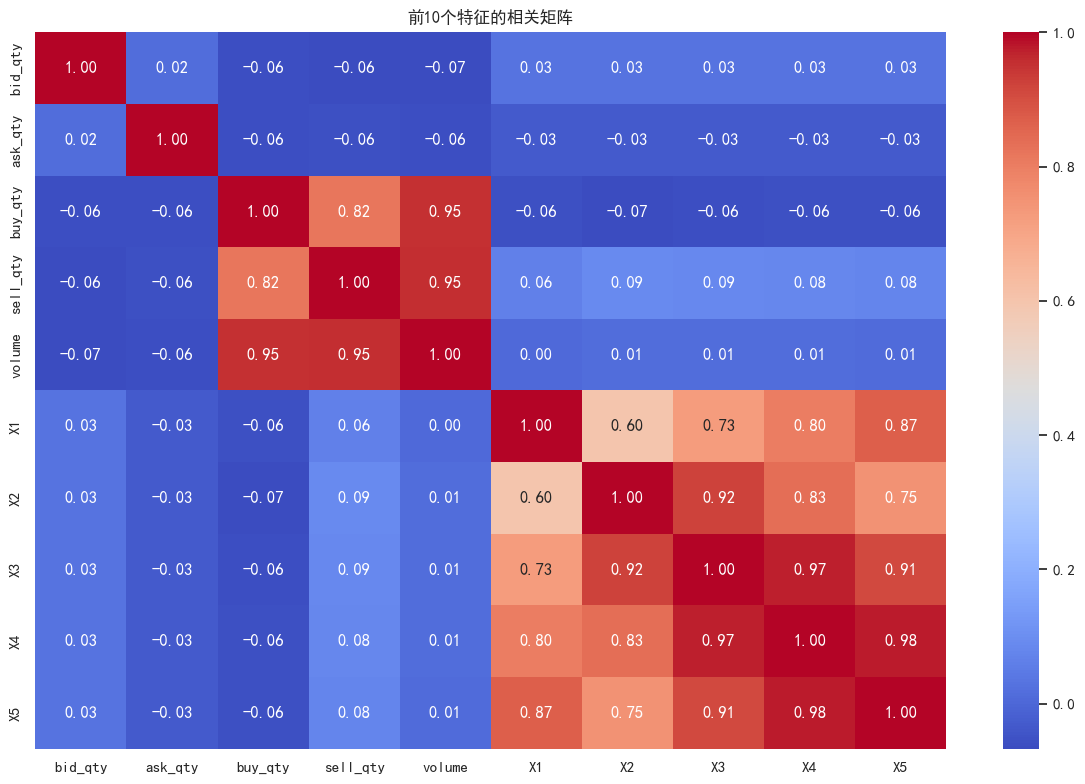

In [3]:
# https://www.kaggle.com/competitions/drw-crypto-market-prediction
# https://github.com/copilot/c/f895d60b-fcd6-4363-b997-8a22a55234f1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import pearsonr
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from utils import setup_chinese_font
setup_chinese_font()
import warnings, os
warnings.filterwarnings("ignore")

# 设置随机种子
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# 加载数据集
DATA_DIR = r"../data/kaggle-drw-crypto-market-prediction"
train_file = os.path.join(DATA_DIR, "train.parquet")
test_file = os.path.join(DATA_DIR, "test.parquet")
submission_file = os.path.join(DATA_DIR, "sample_submission.csv")
train_df = pd.read_parquet(train_file)
test_df = pd.read_parquet(test_file)
sample_submission_df = pd.read_csv(submission_file)

# 显示基本信息
print(f"训练集形状: {train_df.shape}")
print(f"测试集形状: {test_df.shape}")

# 查看训练数据的前几行
print("\n训练数据样本:")
print(train_df.head(3))
print(f"训练数据索引名: {train_df.index.name}")

# 查看测试数据的前几行
print("\n测试数据样本:")
print(test_df.head(3))
print(f"测试数据索引名: {test_df.index.name}")

# 检查列类型和缺失值
print("\n训练数据信息:")
print(train_df.dtypes.value_counts())
print("\n训练数据中的缺失值:")
print(train_df.isnull().sum().sum())

# 检查测试数据的列类型和缺失值
print("\n测试数据信息:")
print(test_df.dtypes.value_counts())
print("\n测试数据中的缺失值:")
print(test_df.isnull().sum().sum())

# 数值列的基本统计信息
print("\n训练数据统计摘要:")
print(train_df.describe().T.head())

# 绘制特征之间的相关性(为了可读性只使用前10个)
plt.figure(figsize=(12, 8))
correlation_matrix = train_df.iloc[:, 0:10].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('前10个特征的相关矩阵')
plt.tight_layout()
plt.savefig('correlation_matrix.png')

In [4]:
# 数据预处理
def preprocess_data(train_df, test_df, target_col=None):
    """
    对训练和测试数据框进行预处理

    参数:
        train_df: 训练数据框
        test_df: 测试数据框
        target_col: 目标列的名称(如果测试数据中有)

    返回:
        处理后的训练特征, 训练标签, 测试特征, 测试ID
    """
    # 保存原始索引
    train_index = train_df.index
    test_ids = test_df.index.values

    # 处理日期索引（如果存在）
    if train_df.index.name == 'timestamp':
        # 转换索引为datetime类型
        train_df.index = pd.to_datetime(train_df.index)

        # 提取日期特征作为新列
        train_df['day_of_week'] = train_df.index.dayofweek
        train_df['month'] = train_df.index.month
        train_df['day'] = train_df.index.day

    # 将训练数据复制为特征集
    train_features = train_df.copy()

    # 获取测试特征
    test_features = test_df.copy()

    # 如果测试数据中存在目标列，则将其移除
    if target_col and target_col in test_features.columns:
        test_features = test_features.drop([target_col], axis=1)

    # 对齐训练和测试数据的特征
    common_features = [col for col in train_features.columns if col in test_features.columns]
    train_features = train_features[common_features]
    test_features = test_features[common_features]

    # 创建目标变量
    # 对于这个比赛，目标变量并未在共享数据中明确给出
    # 假设我们要预测的是未来价格变动，可能编码在其中一列中
    # 或者可以从市场数据中导出

    # 作为占位符，我们使用'volume'作为目标变量进行演示
    # 实际上，你需要确定正确的目标变量
    if 'label' in train_df.columns:
        train_labels = train_df['label'].values
        # 如果label不在common_features中，不需要从train_features中删除
        if 'label' in train_features.columns:
            train_features = train_features.drop(['label'], axis=1)
    elif 'volume' in train_features.columns:
        train_labels = train_features['volume'].values
        train_features = train_features.drop(['volume'], axis=1)

        # 如果测试特征中也存在'volume'，同样将其移除
        if 'volume' in test_features.columns:
            test_features = test_features.drop(['volume'], axis=1)
    else:
        # 如果没有确定目标变量，创建一个虚拟目标用于演示
        print("警告: 未识别到目标变量。使用虚拟目标。")
        train_labels = np.zeros(len(train_features))

    return train_features, train_labels, test_features, test_ids

# 应用预处理
train_features, train_labels, test_features, test_ids = preprocess_data(train_df, test_df)

# 特征缩放
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

print(f"处理后的训练特征形状: {train_features_scaled.shape}")
print(f"处理后的测试特征形状: {test_features_scaled.shape}")

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [11]:
print(train_df.index.name)

timestamp


In [4]:
train_df.columns

Index(['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume', 'X1', 'X2', 'X3',
       'X4', 'X5',
       ...
       'X882', 'X883', 'X884', 'X885', 'X886', 'X887', 'X888', 'X889', 'X890',
       'label'],
      dtype='object', length=896)

In [18]:
# 有“时间戳”列的表格做时间序列降采样
train_df_resampled = train_df.resample('1D').mean()
print(train_df_resampled.shape)
print(train_df_resampled.index.name)
train_df_resampled.to_csv(os.path.join(DATA_DIR, "train_resampled.csv"))

(366, 896)
timestamp


In [19]:
print(test_df.head())

    bid_qty  ask_qty  buy_qty  sell_qty   volume        X1        X2  \
ID                                                                     
1     0.114   12.121   10.587    10.971   21.558 -0.732818  0.512331   
2     2.426    2.962  136.241    12.304  148.545 -0.337995 -0.412176   
3     1.085    2.343   23.390    57.171   80.561  0.111249  0.458221   
4    14.793    1.117  116.518    13.082  129.600 -0.149399 -0.640638   
5     0.033   14.178   43.800    49.836   93.636 -0.694662  0.611254   

          X3        X4        X5  ...      X882      X883      X884      X885  \
ID                                ...                                           
1  -0.041982 -0.598260 -0.517646  ...  1.014336  1.367567  1.584126  1.584126   
2  -0.259468 -0.334809 -0.247443  ...  1.748939  1.848177  0.000131  0.000323   
3   0.466916  0.574081  0.324722  ...  1.704680  1.772028  0.000550  0.003597   
4  -0.873778 -1.026144 -0.508816  ...  0.930946  1.037839  1.382037  1.382037   
5   0.067

In [20]:
test_df.index.name

'ID'

In [23]:
print(test_df.columns)

Index(['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume', 'X1', 'X2', 'X3',
       'X4', 'X5',
       ...
       'X882', 'X883', 'X884', 'X885', 'X886', 'X887', 'X888', 'X889', 'X890',
       'label'],
      dtype='object', length=896)


In [21]:
test_df_resampled = test_df.sample(n=1000, random_state=42)  # 随机抽样1000行
test_df_resampled.to_csv(os.path.join(DATA_DIR, "test_resampled.csv"))

In [22]:
print(sample_submission_df.head())

   ID  prediction
0   1   -0.280233
1   2    1.371969
2   3   -2.045252
3   4   -1.447555
4   5   -1.303901


In [ ]:
# 特征工程数据预处理
def preprocess_data(train_df, test_df):
    print("\n数据预处理...")
    # 分离训练集的特征和标签
    X_train = train_df.drop(columns="label", axis=1)
    y_train = train_df["label"]

    # 分离测试集的特征和标签
    X_test = test_df.drop(columns="label", axis=1)
    y_test = test_df["label"]